# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
%pip install matplotlib tensorflow tensorflow_io

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return wav

## 2.3 Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

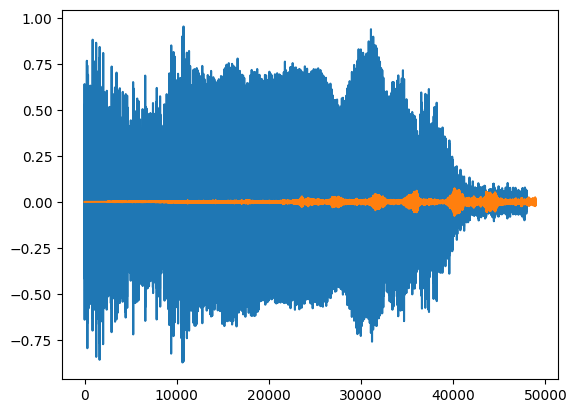

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [6]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [9]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=31999>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [42]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [43]:
spectrogram, label = preprocess(filepath, label)

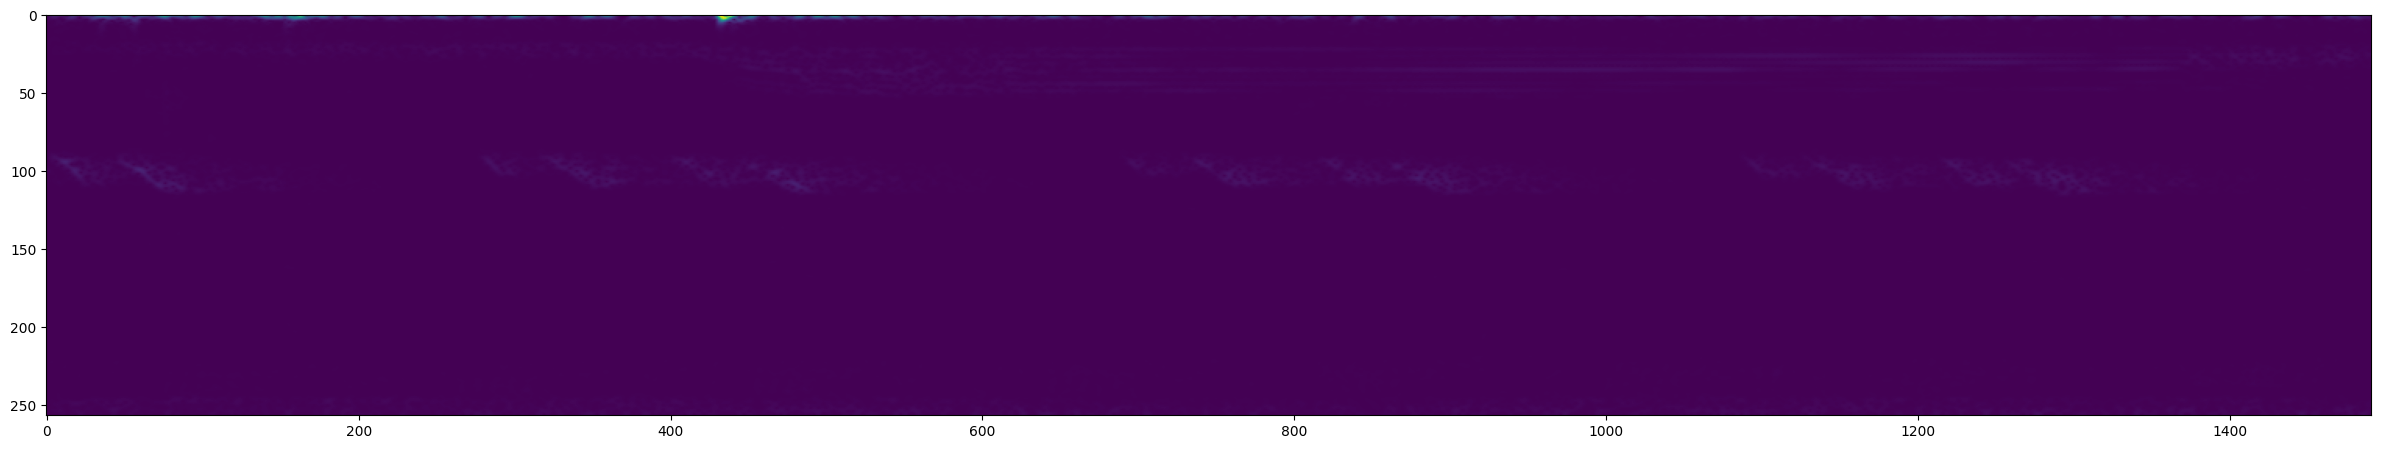

In [44]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [18]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [19]:
samples, labels = train.as_numpy_iterator().next()

In [20]:
samples.shape

(16, 1491, 257, 1)

In [21]:
labels

array([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [23]:
model = Sequential()
model.add(tf.keras.Input(shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      1160      
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 32)                96310048  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96311401 (367.40 MB)
Trainable params: 96311401 (367.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [26]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 128s 3s/step - loss: 2.6427 - recall: 0.8797 - precision: 0.7202 - val_loss: 0.2547 - val_recall: 0.9516 - val_precision: 0.9077
Epoch 2/4
36/36 [==============================] - 100s 3s/step - loss: 0.1737 - recall: 0.9338 - precision: 0.9527 - val_loss: 0.0313 - val_recall: 0.9857 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 102s 3s/step - loss: 0.0221 - recall: 0.9863 - precision: 0.9931 - val_loss: 0.0232 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 102s 3s/step - loss: 0.0229 - recall: 0.9874 - precision: 0.9937 - val_loss: 0.0144 - val_recall: 0.9844 - val_precision: 1.0000


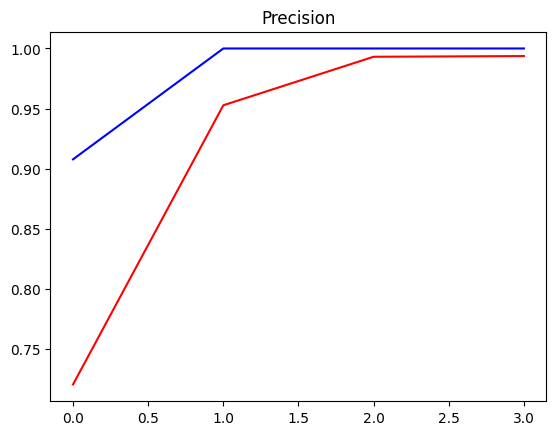

In [27]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

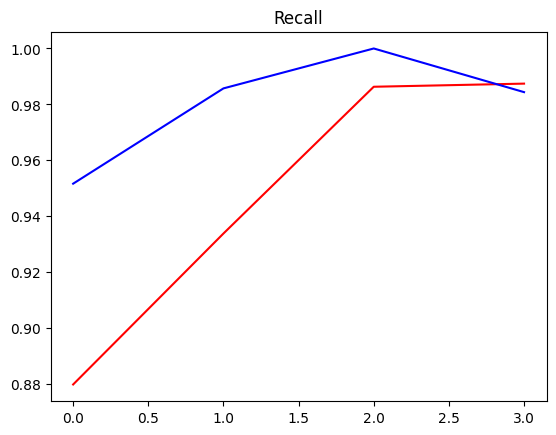

In [28]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

**Inference on a Single Batch**

In [47]:
X_test, y_test = test.as_numpy_iterator().next()

In [48]:
y_test.astype(int)

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [40]:
y_test.shape

(16,)

In [49]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 866ms/step


In [51]:
yhat.astype(int)

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])